In [23]:
#importing relevant packages for this forecast
from prophet import Prophet
import pandas as pd
import os
from datetime import date as dt
import plotly.express as px

In [4]:
revenue = pd.read_csv(f'{os.getcwd()}/values-2018-2021.csv', sep = ';', encoding = 'latin-1')
revenue.head()

,DT_PAGAMENTO,VL_PAGO,VL_PARCELAS
0,01/02/2018,1416.59,1416.59
1,05/02/2018,2131.73,2131.73
2,06/02/2018,761.78,761.78
3,06/02/2018,4023.79,4023.79
4,07/02/2018,14.40,14.40


In [5]:
#defining a set of columns for treatment
float_columns = revenue.select_dtypes(include = 'float64').columns

revenue[float_columns] = revenue[float_columns].round(2)
revenue['DT_PAGAMENTO'] = revenue['DT_PAGAMENTO'].astype('datetime64')
revenue['DT_PAGAMENTO'] = revenue['DT_PAGAMENTO'].dt.strftime('%Y-%m-%d')
revenue

,DT_PAGAMENTO,VL_PAGO,VL_PARCELAS
0,2018-01-02,1416.59,1416.59
1,2018-05-02,2131.73,2131.73
2,2018-06-02,761.78,761.78
3,2018-06-02,4023.79,4023.79
4,2018-07-02,14.40,14.40
...,...,...,...
15425,2021-09-15,2202.37,2202.37
15426,2021-09-15,808.00,45.00
15427,2021-09-15,1160.66,1194.50
15428,2021-09-15,1842385.00,1834095.00


In [6]:
#selecting the relevant columns for fiting the model and renaming it to the Prophet pattern
df = revenue[['DT_PAGAMENTO','VL_PAGO']]
df = df.rename(columns = {'DT_PAGAMENTO': 'ds','VL_PAGO' : 'y'})
df

,ds,y
0,2018-01-02,1416.59
1,2018-05-02,2131.73
2,2018-06-02,761.78
3,2018-06-02,4023.79
4,2018-07-02,14.40
...,...,...
15425,2021-09-15,2202.37
15426,2021-09-15,808.00
15427,2021-09-15,1160.66
15428,2021-09-15,1842385.00


In [116]:
#calling the model and fitting it

model = Prophet(growth = 'linear', seasonality_mode = "multiplicative")
model.add_country_holidays(country_name = 'BRA')
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.86686


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       62105.9   2.93445e-05       1333.99     0.01571           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         62108   0.000331661       3390.81           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       62111.6    0.00126992       8496.05       0.256       0.256      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       62126.7     0.0331176       3876.45           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         62145   0.000303887       6910.01      0.3063           1      604   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [97]:
#generating a dataframe with desired period of forecasting (2 years in this case)

dates = model.make_future_dataframe(periods = 1826)
dates.tail()

,ds
2551,2025-12-27
2552,2025-12-28
2553,2025-12-29
2554,2025-12-30
2555,2025-12-31


In [117]:
#calling the model to predict based on the previously built dates dataframe
forecast = model.predict(dates)
forecast[['ds','yhat','yhat_lower','yhat_upper','trend']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend
2551,2025-12-27,29521.387396,-1.559182e+07,1.470611e+07,76783.844361
2552,2025-12-28,8953.408669,-7.003902e+06,6.547730e+06,76801.565659
2553,2025-12-29,114419.887743,-5.326708e+07,5.395542e+07,76819.286957
2554,2025-12-30,-14888.333544,-8.782246e+06,9.052053e+06,76837.008255
2555,2025-12-31,-3877.798261,-6.028754e+06,5.426263e+06,76854.729553


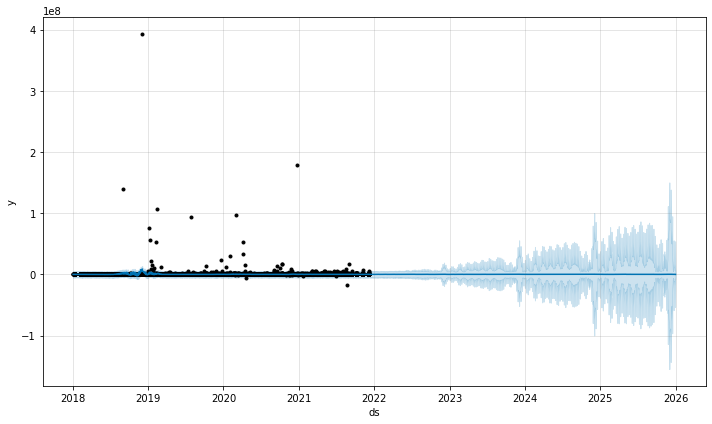

In [118]:
figure = model.plot(forecast)

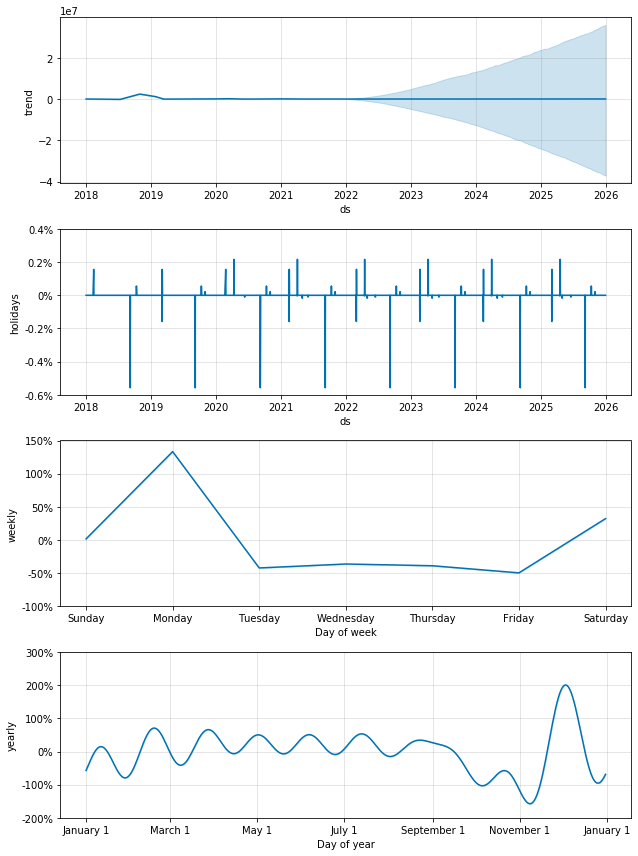

In [119]:
#seeing the result but in components (day, day of week and yearly)

figure_2 = model.plot_components(forecast)

In [120]:
graph = px.line(forecast, 
                x = 'ds', 
                y = ['yhat','yhat_lower','yhat_upper','trend'], 
                template ='plotly_white',
                title = 'Yhat intervals for forecast',
                labels = {'value':'Values','ds':'Date'})
graph.show()

In [121]:
graph_2 = px.line(forecast[forecast['ds']> '2021-01-01'], 
                  x = 'ds', 
                  y = 'yearly',
                  template = 'plotly_white',
                  title = 'Yearly Forecast since 2021',
                  labels = {'yearly':'Total revenue','ds':'Date'})
graph_2.show()